In [1]:
import nibabel as nib
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim

In [2]:
class Namespace:
    """
    a class generate parser for cmd line args
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [3]:
"""
packages that generate train/test dataset
"""
from FormatData import generate_data, parser as data_parser

2022-03-14 20:56:08.319514: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [4]:
"""
packages that trains network
"""
from Training import train_network
from utils.model import parser as model_parser

In [5]:
"""
packages that test network
"""
from Testing import test_model

In [48]:
"""
packages that plot graphs
"""
import matplotlib.pyplot as plt
%matplotlib inline
def plot_loss(cmd):
    """
    A function that used to plot the loss curve for the trained network.
    Args:
        cmd: String, the command line in the terminal
    """
    args = model_parser().parse_args(cmd.split())
    history = train_network(args)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def show_slices(slices):
   """ 
   Function to display row of image slices 
   """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap=plt.cm.gray, origin="lower", interpolation='nearest')

In [7]:
# A simple test to verify the algorithm mask_nii_data from utils.nii_utils correctly generates the 1x1 patch from (a) given volume(s) DWI
from utils.nii_utils import mask_nii_data
s02_mask_path = '../Net/datasets/mask/mask_s02_still.nii'
s02_mask_data = nib.load(s02_mask_path).get_fdata()
print(s02_mask_data.shape)
# generate a random mask
random_mask = np.zeros((s02_mask_data.shape[0],s02_mask_data.shape[1], s02_mask_data.shape[2]))
print(random_mask.shape)
# select some pixels' values in the random_mask turn into 1
# randomly select 4 paris of x, y value
for i in range(4):
    rand_x = np.random.randint(low=0, high=s02_mask_data.shape[0])
    rand_y = np.random.randint(low=0, high=s02_mask_data.shape[1])
    rand_z = np.random.randint(low=0, high=s02_mask_data.shape[2])
    # set the corresponding pixel to have value 1
    random_mask[rand_x][rand_y][rand_z] = 1
# by this, we know the ground truth for this test. The number of 1s in the mask = the number of 1x1 pacth generated from the algorithm
# we apply the random mask onto the s02_mask
data = mask_nii_data(data=s02_mask_data, mask=random_mask)

(84, 84, 50)
(84, 84, 50)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (4, 1) the ratio of masked voxel is: 1.1337868480725624e-05


<strong>Interpret the result from the algorithm test.</strong>
The s02_mask has only one volume of shape (84,84,50). The random mask has a shape (84,84,50).</br>
We randomly turned 4 pixels in the random mask to 1. Then apply the random mask to the s02_mask.</br>
<strong>What we expect to see, there should be 4 patches generated for each volume of s02_mask.</strong></br>
Results show that the data afer masking (by the random mask) has a shape (4,1). Where 4 represents the number of 1x1 patches and 1 represent the volume of s02_mask.</br>
Therefore, it suggests the algorithm works fine.

(10332, 3, 3, 96)
(10332, 3, 3, 96)


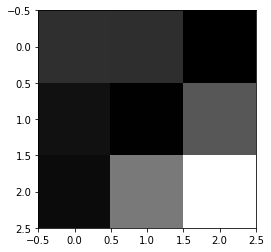

In [34]:
# generate a 2d patch
from utils.data_utils import gen_2d_patches
mask = nib.load('../Net/datasets/mask/mask_s01_still.nii')
data = nib.load('/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/diffusion.nii')
mask = np.array(mask.dataobj)
data = np.array(data.dataobj)
data = data / data.mean() - 1.0

base = 1
patch_size = 3
label_size = 3
mask = mask[base:-base, base:-base, base:-base]
data = data[:, :, base:-base, :]

pacthes = gen_2d_patches(data, mask, patch_size, label_size)
print(pacthes.shape)
plt.imshow(pacthes[0,:,:,0], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(84, 84, 48, 96) (82, 82, 48)
(3640, 3, 3, 3, 96)
(3640, 3, 3, 3, 96)


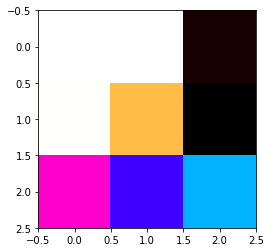

In [62]:
# generate a 3d patch
from utils.data_utils import gen_3d_patches
mask = nib.load('../Net/datasets/mask/mask_s01_still.nii')
data = nib.load('/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/diffusion.nii')
mask = np.array(mask.dataobj)
data = np.array(data.dataobj)
data = data / data.mean() - 1.0

base = 1
patch_size = 3
label_size = 3
mask = mask[base:-base, base:-base, base:-base]
data = data[:, :, base:-base, :]

pacthes = gen_3d_patches(data, mask, patch_size, label_size)
print(pacthes.shape)
plt.imshow(pacthes[0,:,:,:,0], cmap='gray')

_______

<h3>Experiment 1. Discover the number of hidden acquired to produce promising each NODDI measure.</h3>

___

<h4>Test NDI</h4>
<strong>Training subject: s01_still<br/>

Test subject: s02_still<br/>

Outcome: NDI<br/></strong>


<h4>Data Preprocessing</h4>

In [9]:
"""
Generate the base dataset for s01_still and s02_still first.
"""
cmd = "--base --label_type N --subjects s01_still s02_still"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating for s02_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)


<strong>Interpret the result. </strong><br/>
The base dataset for s01_still and s02_still has the same shape.<br/>
The data has shape (84, 84, 50, 96); where (84, 84, 50) is the width, height and slice of each volume of DWI; where 96 is the volume of DWI<br/>
The label has shape (84, 84, 50, 1); where (84, 84, 50) is the width, height and slice of each volume of label; where 1 is the volume of label (because we are predicting NDI only in this case)


In [9]:
"""
Generate training dataset NDI for ANN.
"""
cmd = "--subjects s01_still --fc1d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (82889, 96) the ratio of masked voxel is: 0.23494614512471657
training dataset has shape:(82889, 96)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (82889, 1) the ratio of masked voxel is: 0.23494614512471657
training label has shape:(82889, 1)


<strong>
Interpret this result.
</strong> 
After the mask is applied to 96 volumes of DWI imgs, for each volume of img, there are 82889 1x1 patches (i.e. voxels) generated. Therefore, in total there are 82889x96=7957344 values as training dataset. <br/>
For each masked voxel, there is a corresponding NDI value. Therefore, the number of NDI values is the same as the number of masked voxels (82889). Becasue we are examine NDI only, hence only one value associated with each masked voxel.

<img src="/home/vw/Desktop/IndividualProject/Graphs/ANN Graphs/ANN Data Preprocessing.png" width="800" height="400">

In [15]:
# Generate the dataset for 2D CNN
cmd = "--subjects s01_still --conv2d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(82641, 3, 3, 96)
saved patches has shape: (82641, 3, 3, 96)
(82641, 1, 1, 1)
svaed labels has shape: (82641, 1, 1, 1)


<strong>
Interpret the result
</strong>
The masked voxels are 82641. For each masked voxel, there is a 3x3 patch which includes this masked voxel at the centre of the patch; but also including its 8 neighbouring voxels. Each masked voxel has 96 volumes of the 3x3 patch. Therefore, in total there are 82641 x 3 x 3 x 96 = 71401824 values as the training dataset.<br/>
Herein, because we only examine NDI. For each masked voxel, there is a corresponded predicted NDI value. Hence the number of masked voxels is the same for label and data. The label size is 1x1 because it is the NDI parameter for the masked voxel. The masked voxel has a size 1x1. And there is only one of this value for each masked voxel, since only NDI is considered.

<img src="/home/vw/Desktop/IndividualProject/Graphs/2D CNN graphs/2D CNN Data Preprocessing.png" width="800" height="400">

In [16]:
# Generate the dataset for 3D CNN
cmd = "--subjects s01_still --conv3d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(82641, 3, 3, 3, 96)
saved patches has shape: (82641, 2592)
(82, 82, 48, 1) (82, 82, 48)
(82641, 1, 1, 1, 1)
svaed labels has shape: (82641, 1, 1, 1, 1)


<strong>
Interpret the result
</strong>
The masked voxels are 82641. For each masked voxel, there is a 3x3x3 patch which includes this masked voxel at the centre of the patch; but also including its 26 neighbouring voxels. Each masked voxel has 96 volumes of 3x3x3 patch. Therefore, in total there are 82641 x 3 x 3 x 3 x 96 = 214205472 values as the training dataset.<br/>
Herein, because we only examine NDI. For each masked voxel, there is a corresponded predicted NDI value. Hence the number of masked voxels is the same for label and data. The label size is 1x1x1 because it is the NDI parameter for the masked voxel. The masked voxel has a size 1x1x1. And there is only one of this value for each masked voxel, since only NDI is considered.

In [11]:
"""
Using nib to fetch the ground truth img
"""
s02_NDI_path = '../Data-NODDI/s02_still/s02_still_NDI.nii'
s02_mask_path = '../Net/datasets/mask/mask_s02_still.nii'
s02_NDI_img = nib.load(s02_NDI_path)
s02_NDI_img_data = s02_NDI_img.get_fdata()
s02_mask_img = nib.load(s02_mask_path)
s02_mask_img_data = s02_mask_img.get_fdata()

___

<h4>Training</h4>

<strong>
The split between validation dataset and the training dataset is 5:5<br/>
The learning rate is 0.0001 to ensure a smooth learning<br/>
Herein, at most 6 hidden fully connected layers are trained.<br/>
Loss curve for each training is plotted.<br/>
The test result is also generated -- evaluating the RMSE and SSIM between pred and reference.<br/>
The reference image and the genereated image are displayed side by side.</br>
The difference map between the ref img and the pred img is also generated
</strong>

<strong>1 layer</strong>

ANN

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense (Dense)                (None, 150)               14550     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
['N']
Training start ...


2022-03-14 21:03:16.861070: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 21:03:16.862113: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2022-03-14 21:03:16.866570: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so.10.1
2022-03-14 21:03:16.869532: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Epoch 1/100
  1/162 [..............................] - ETA: 0s - loss: 0.4368 - accuracy: 0.0195WARNING:tensorflow:From /home/vw/anaconda3/envs/project/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
112/162 [===================>..........] - ETA: 0s - loss: 0.3293 - accuracy: 0.0175

2022-03-14 21:03:17.175929: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 21:03:17.178583: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 21:03:17.179375: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 21:03:17.181568: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_21_03_17
2022-03-14 21:03:17.182090: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_21_03_17/vw.trace.json.gz
2022-03-14 21:03:17.182144: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 21:03:17.184313: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 0s 2ms/step - loss: 0.3064 - accuracy: 0.0188 - val_loss: 0.1810 - val_accuracy: 0.0187
Epoch 2/100
162/162 [==============================] - 0s 1ms/step - loss: 0.2278 - accuracy: 0.0211 - val_loss: 0.1498 - val_accuracy: 0.0200
Epoch 3/100
162/162 [==============================] - 0s 1ms/step - loss: 0.1999 - accuracy: 0.0215 - val_loss: 0.1404 - val_accuracy: 0.0219
Epoch 4/100
162/162 [==============================] - 0s 1ms/step - loss: 0.1784 - accuracy: 0.0222 - val_loss: 0.1346 - val_accuracy: 0.0227
Epoch 5/100
162/162 [==============================] - 0s 1ms/step - loss: 0.1649 - accuracy: 0.0231 - val_loss: 0.1298 - val_accuracy: 0.0234
Epoch 6/100
162/162 [==============================] - 0s 1ms/step - loss: 0.1571 - accuracy: 0.0226 - val_loss: 0.1266 - val_accuracy: 0.0251
Epoch 7/100
162/162 [==============================] - 0s 1ms/step - loss: 0.1492 - accuracy: 0.0239 - val_loss: 0.1245 - val_accuracy: 0.0227
Epoch 8/100

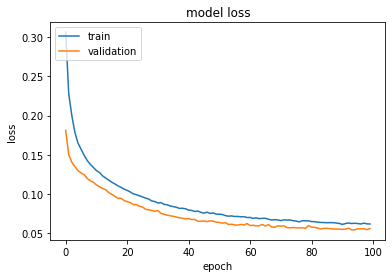

In [13]:
# 1 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 1 --train --label_type N"
plot_loss(cmd)

<img src="/home/vw/Desktop/IndividualProject/Graphs/ANN Graphs/ANN Input Layer.png" width="800" height="400">

To verify this, the output shape from the Input layer is [(None, 96)]. Since we are using 96 DWI images as input size. Therefore, it is true that the graph shows the correct thing. The output from the Input layer is N number of masked voxel. Each voxel has size (1,1). Therefore, in total 96 values

<img src="/home/vw/Desktop/IndividualProject/Graphs/ANN Graphs/ANN FC Layer.png" width="800" height="400">

To verify this, the output shape after the first dense layer is (None, 150). Where 150 is the output dimenstion chosen for the model. Also, to verify the number of trained parameters. In this case N=96, M=150; the number of trained parameters are (96+1)x150=14550.

<img src="/home/vw/Desktop/IndividualProject/Graphs/Dropout Layer.png" width="800" height="400">

There are no parameter trained at this layer

<img src="/home/vw/Desktop/IndividualProject/Graphs/Output Layer.png" width="800" height="400">

In this case, we only have one neuron at the output layer. Becasue we are examing the network performance on deriving NDI. Therefore, the output shape is (1x1) patch, i.e. the NDI value of the chosen voxel. To verify the number of parameters trained, M=150 and output dimension is 1. So (150+1)x1=151 trained parameters

In [14]:
# 1 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 1 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

96-fc1d-patch_1-base_1-layer_1
(84, 50, 96)
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               14550     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
testing data shape: (84, 84, 50, 96)
prediction has shape: (84, 84, 50, 1)
prediction after repack has shape: (84, 84, 50, 1)
pred shape: (93643, 1)
gt has shape: (93643, 1)
the RMSE loss is: 0.0863138618

/home/vw/anaconda3/envs/project/lib/python3.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


2D CNN

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 150)         129750    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 1)           151       
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
['N']
Training start ...
Epoch 1/100


2022-03-14 21:25:18.822943: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 21:25:18.823059: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


 70/162 [===========>..................] - ETA: 0s - loss: 0.3263 - accuracy: 0.0312

2022-03-14 21:25:19.138420: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 21:25:19.152804: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 21:25:19.153071: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 21:25:19.153758: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_21_25_19
2022-03-14 21:25:19.154146: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_21_25_19/vw.trace.json.gz
2022-03-14 21:25:19.154204: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 21:25:19.154670: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 1s 4ms/step - loss: 0.2581 - accuracy: 0.0341 - val_loss: 0.1611 - val_accuracy: 0.0085
Epoch 2/100
162/162 [==============================] - 1s 3ms/step - loss: 0.1674 - accuracy: 0.0392 - val_loss: 0.1492 - val_accuracy: 0.0093
Epoch 3/100
162/162 [==============================] - 0s 3ms/step - loss: 0.1515 - accuracy: 0.0417 - val_loss: 0.1368 - val_accuracy: 0.0088
Epoch 4/100
162/162 [==============================] - 0s 3ms/step - loss: 0.1439 - accuracy: 0.0425 - val_loss: 0.1303 - val_accuracy: 0.0089
Epoch 5/100
162/162 [==============================] - 0s 3ms/step - loss: 0.1377 - accuracy: 0.0442 - val_loss: 0.1278 - val_accuracy: 0.0090
Epoch 6/100
162/162 [==============================] - 0s 3ms/step - loss: 0.1343 - accuracy: 0.0443 - val_loss: 0.1263 - val_accuracy: 0.0089
Epoch 7/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1293 - accuracy: 0.0456 - val_loss: 0.1300 - val_accuracy: 0.0094
Epoch 8/100

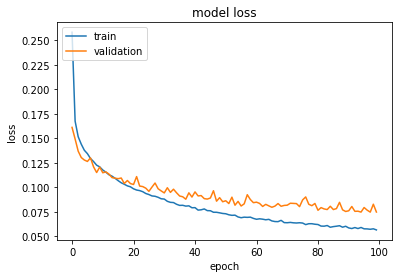

In [17]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 1 --train --label_type N"
plot_loss(cmd)

<img src="/home/vw/Desktop/IndividualProject/Graphs/2D CNN graphs/2D CNN Input Layer.png" width="800" height="400">

To verify this, the output shape from the Input layer is [(None, 3, 3, 96)]. Since we are using 96 DWI images as input size. Therefore, it is true that the graph shows the correct thing. The output from the Input layer is N number of 3x3 patches contains the masked voxel at the centre and it neighbouring 8 voxels. Each voxel has size (1,1), suggest the information at this voxel.

<img src="/home/vw/Desktop/IndividualProject/Graphs/2D CNN graphs/2D CNN Conv Layer.png" width="800" height="400">

To verify this, the output shape after the first dense layer is (None, 1, 1, 150). Where 150 is the output dimenstion chosen for the model. Also, to verify the number of trained parameters. In this case N=96, M=150; the number of trained parameters are (3x3x96+1)x150=129750.

<img src="/home/vw/Desktop/IndividualProject/Graphs/Dropout Layer.png" width="800" height="400">

<img src="/home/vw/Desktop/IndividualProject/Graphs/2D CNN graphs/2D CNN Output Layer.png" width="800" height="400">

In this case, we only have one neuron at the output layer. Becasue we are examing the network performance on deriving NDI. Therefore, the output shape is (1x1) patch, i.e. the NDI value of the central masked voxel. To verify the number of parameters trained, M=150 and output dimension is 1. So (150+1)x1=151 trained parameters

In [18]:
# 1 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 1 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

96-conv2d-patch_3-base_1-layer_1
(84, 84, 96)
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 82, 150)       129750    
_________________________________________________________________
dropout_4 (Dropout)          (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 82, 82, 1)         151       
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
testing data shape: (50, 84, 84, 96)
prediction has shape: (50, 82, 82, 1)
prediction after repack has shape: (84, 84, 50, 1)
pred shape: (93643, 1)
gt has shape: (93643, 1)
the RMSE loss is: 0.113517

/home/vw/anaconda3/envs/project/lib/python3.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


3D CNN

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 1, 1, 1, 1)        151       
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
['N']
Training start ...
Epoch 1/100


2022-03-14 21:42:02.212757: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 21:42:02.212935: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


 28/162 [====>.........................] - ETA: 0s - loss: 0.3091 - accuracy: 0.0304

2022-03-14 21:42:02.531371: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 21:42:02.545853: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 21:42:02.546109: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 21:42:02.546898: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_21_42_02
2022-03-14 21:42:02.547306: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_21_42_02/vw.trace.json.gz
2022-03-14 21:42:02.547368: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 21:42:02.547840: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 1s 8ms/step - loss: 0.2048 - accuracy: 0.0371 - val_loss: 0.1546 - val_accuracy: 0.0088
Epoch 2/100
162/162 [==============================] - 1s 6ms/step - loss: 0.1535 - accuracy: 0.0417 - val_loss: 0.1475 - val_accuracy: 0.0091
Epoch 3/100
162/162 [==============================] - 1s 7ms/step - loss: 0.1442 - accuracy: 0.0439 - val_loss: 0.1405 - val_accuracy: 0.0093
Epoch 4/100
162/162 [==============================] - 1s 6ms/step - loss: 0.1383 - accuracy: 0.0438 - val_loss: 0.1347 - val_accuracy: 0.0094
Epoch 5/100
162/162 [==============================] - 1s 6ms/step - loss: 0.1323 - accuracy: 0.0451 - val_loss: 0.1245 - val_accuracy: 0.0094
Epoch 6/100
162/162 [==============================] - 1s 6ms/step - loss: 0.1279 - accuracy: 0.0460 - val_loss: 0.1361 - val_accuracy: 0.0098
Epoch 7/100
162/162 [==============================] - 1s 6ms/step - loss: 0.1241 - accuracy: 0.0463 - val_loss: 0.1209 - val_accuracy: 0.0095
Epoch 8/100

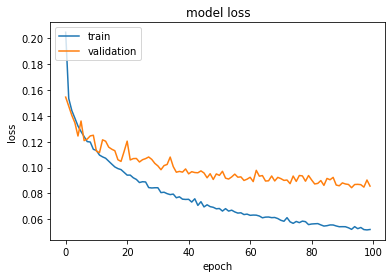

In [21]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 1 --train --label_type N"
plot_loss(cmd)

In [22]:
# 1 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 1 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

96-conv3d-patch_3-base_1-layer_1
(84, 84, 50)
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
dropout_8 (Dropout)          (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 82, 82, 48, 1)     151       
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
testing data shape: (1, 84, 84, 50, 96)
prediction has shape: (1, 82, 82, 48, 1)
prediction after repack has shape: (84, 84, 50, 1)
pred shape: (93643, 1)
gt has shape: (93643, 1)
the RMSE loss is: 0

/home/vw/anaconda3/envs/project/lib/python3.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


the ssim score for ann is: 0.9771567404801349
(84, 50)
pos: 1039 zero: 2448 neg: 713


Text(0.5, 0.98, 'Difference map ANN')

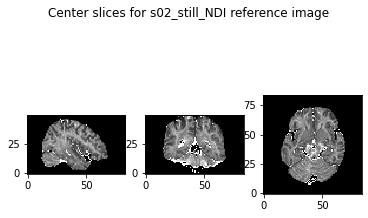

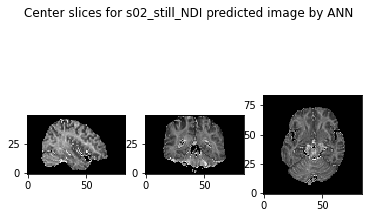

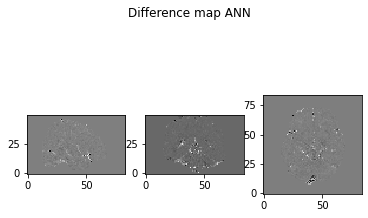

In [49]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_1.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_1.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_1.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

# cnn2d0 = cnn2d_data[26, :, :]
# cnn2d1 = cnn2d_data[:, 30, :]
# cnn2d2 = cnn2d_data[:, :, 16]
# show_slices([cnn2d0, cnn2d1, cnn2d2])
# plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
# (cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
# print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

# cnn3d0 = cnn3d_data[26, :, :]
# cnn3d1 = cnn3d_data[:, 30, :]
# cnn3d2 = cnn3d_data[:, :, 16]
# show_slices([cnn3d0, cnn3d1, cnn3d2])
# plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
# (cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
# print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# # plot the difference map between the imgs by the lib
# anndiff0 = anndiff[26, :, :]
# anndiff1 = anndiff[:, 30, :]
# anndiff2= anndiff[:, :, 16]
# show_slices([anndiff0, anndiff1, anndiff2])
# plt.suptitle("Difference map ANN")

# cnn2ddiff0 = cnn2ddiff[26, :, :]
# cnn2ddiff1 = cnn2ddiff[:, 30, :]
# cnn2ddiff2 = cnn2ddiff[:, :, 16]
# show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
# plt.suptitle("Difference map 2D CNN")

# cnn3ddiff0 = cnn3ddiff[26, :, :]
# cnn3ddiff1 = cnn3ddiff[:, 30, :]
# cnn3ddiff2 = cnn3ddiff[:, :, 16]
# show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
# plt.suptitle("Difference map 3D CNN")

anndiff0 = ref_slice_0 - ann0
anndiff1 = ref_slice_1 - ann1
anndiff2 = ref_slice_2 - ann2
print(anndiff0.shape)
neg = 0
zero = 0
pos = 0
for i in range(anndiff0.shape[0]):
    for j in range(anndiff0.shape[1]):
        if -1 < anndiff0[i][j] < 0:
            neg += 1
        elif anndiff0[i][j] == 0:
            zero += 1
        elif 1 > anndiff0[i][j] >0:
            pos += 1
print('pos: ' + str(pos) + ' zero: ' + str(zero) + ' neg: ' + str(neg))
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

<strong>2 layer</strong>

ANN

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_9 (Dropout)          (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
Total params: 37,351
Trainable params: 37,351
Non-trainable params: 0
_________________________________________________________________
['N']
Training start ...
Epoch 1/100
  1/162 [..............................] - ETA: 0s - loss: 0.4785 - accuracy: 

2022-03-14 22:26:36.979344: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:26:36.979485: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 22:26:37.175033: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


121/162 [=====================>........] - ETA: 0s - loss: 0.2601 - accuracy: 0.0192

2022-03-14 22:26:37.189195: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 22:26:37.189431: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 22:26:37.190191: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_22_26_37
2022-03-14 22:26:37.190627: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_22_26_37/vw.trace.json.gz
2022-03-14 22:26:37.190696: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 22:26:37.191215: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_22_26_37
2022-03-14 22:26:37.191254: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped 

162/162 [==============================] - 0s 2ms/step - loss: 0.2434 - accuracy: 0.0191 - val_loss: 0.1483 - val_accuracy: 0.0204
Epoch 2/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1717 - accuracy: 0.0215 - val_loss: 0.1349 - val_accuracy: 0.0214
Epoch 3/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1529 - accuracy: 0.0229 - val_loss: 0.1278 - val_accuracy: 0.0242
Epoch 4/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1402 - accuracy: 0.0256 - val_loss: 0.1206 - val_accuracy: 0.0243
Epoch 5/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1328 - accuracy: 0.0266 - val_loss: 0.1171 - val_accuracy: 0.0295
Epoch 6/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1256 - accuracy: 0.0288 - val_loss: 0.1104 - val_accuracy: 0.0260
Epoch 7/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1200 - accuracy: 0.0302 - val_loss: 0.1052 - val_accuracy: 0.0309
Epoch 8/100

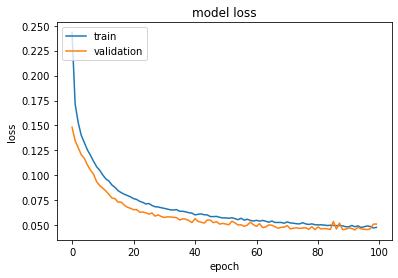

96-fc1d-patch_1-base_1-layer_2
(84, 50, 96)
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_5 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_10 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
Total params: 37,351
Trainable params: 37,351
Non-trainable params: 0
_________________________________________________________________
testing data shape: (84, 84, 50, 96)
prediction has shape: (84, 84, 50,

/home/vw/anaconda3/envs/project/lib/python3.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


In [50]:
# 2 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 2 --train --label_type N"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 2 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 1)           151       
Total params: 152,551
Trainable params: 152,551
Non-trainable params: 0
_________________________________________________________________
['N']
Training start ...
Epoch 1/100


2022-03-14 22:28:12.661113: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:28:12.661190: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


 52/162 [========>.....................] - ETA: 0s - loss: 0.2435 - accuracy: 0.0382

2022-03-14 22:28:12.998474: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:28:13.018932: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 22:28:13.019198: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 22:28:13.020020: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_22_28_13
2022-03-14 22:28:13.020464: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_22_28_13/vw.trace.json.gz
2022-03-14 22:28:13.020526: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 22:28:13.021185: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 1s 5ms/step - loss: 0.2015 - accuracy: 0.0376 - val_loss: 0.1525 - val_accuracy: 0.0086
Epoch 2/100
162/162 [==============================] - 1s 3ms/step - loss: 0.1586 - accuracy: 0.0409 - val_loss: 0.1385 - val_accuracy: 0.0090
Epoch 3/100
162/162 [==============================] - 1s 3ms/step - loss: 0.1462 - accuracy: 0.0425 - val_loss: 0.1411 - val_accuracy: 0.0089
Epoch 4/100
162/162 [==============================] - 1s 3ms/step - loss: 0.1377 - accuracy: 0.0443 - val_loss: 0.1210 - val_accuracy: 0.0092
Epoch 5/100
162/162 [==============================] - 0s 3ms/step - loss: 0.1311 - accuracy: 0.0455 - val_loss: 0.1190 - val_accuracy: 0.0092
Epoch 6/100
162/162 [==============================] - 1s 3ms/step - loss: 0.1256 - accuracy: 0.0461 - val_loss: 0.1231 - val_accuracy: 0.0091
Epoch 7/100
162/162 [==============================] - 0s 3ms/step - loss: 0.1203 - accuracy: 0.0474 - val_loss: 0.1138 - val_accuracy: 0.0098
Epoch 8/100

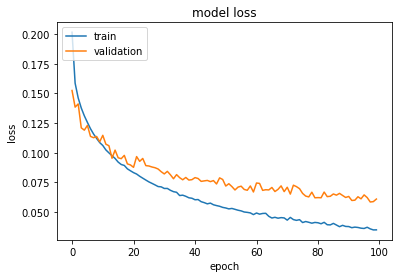

96-conv2d-patch_3-base_1-layer_2
(84, 84, 96)
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_12 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 82, 82, 1)         151       
Total params: 152,551
Trainable params: 152,551
Non-trainable params: 0
_________________________________________________________________
testing data shape: (50, 84, 84, 96)
prediction has shape: (50, 82,

In [51]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 2 --train --label_type N"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 2 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 1, 1, 1, 1)        151       
Total params: 411,751
Trainable params: 411,751
Non-trainable params: 0
_________________________________________________________________
['N']
Training start ...
Epoch 1/100


2022-03-14 22:29:13.085052: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:29:13.085149: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


 26/162 [===>..........................] - ETA: 0s - loss: 0.2542 - accuracy: 0.0335

2022-03-14 22:29:13.446408: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:29:13.466712: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 22:29:13.466954: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 22:29:13.467744: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_22_29_13
2022-03-14 22:29:13.468181: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_22_29_13/vw.trace.json.gz
2022-03-14 22:29:13.468240: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 22:29:13.468749: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 1s 9ms/step - loss: 0.1866 - accuracy: 0.0382 - val_loss: 0.1541 - val_accuracy: 0.0087
Epoch 2/100
162/162 [==============================] - 1s 8ms/step - loss: 0.1514 - accuracy: 0.0421 - val_loss: 0.1463 - val_accuracy: 0.0091
Epoch 3/100
162/162 [==============================] - 1s 8ms/step - loss: 0.1392 - accuracy: 0.0445 - val_loss: 0.1342 - val_accuracy: 0.0096
Epoch 4/100
162/162 [==============================] - 1s 8ms/step - loss: 0.1322 - accuracy: 0.0453 - val_loss: 0.1258 - val_accuracy: 0.0095
Epoch 5/100
162/162 [==============================] - 1s 7ms/step - loss: 0.1256 - accuracy: 0.0467 - val_loss: 0.1191 - val_accuracy: 0.0096
Epoch 6/100
162/162 [==============================] - 1s 7ms/step - loss: 0.1214 - accuracy: 0.0467 - val_loss: 0.1149 - val_accuracy: 0.0100
Epoch 7/100
162/162 [==============================] - 1s 7ms/step - loss: 0.1143 - accuracy: 0.0482 - val_loss: 0.1124 - val_accuracy: 0.0101
Epoch 8/100

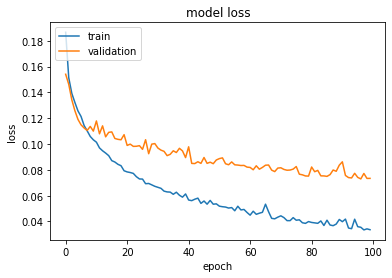

96-conv3d-patch_3-base_1-layer_2
(84, 84, 50)
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_14 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 82, 82, 48, 1)     151       
Total params: 411,751
Trainable params: 411,751
Non-trainable params: 0
_________________________________________________________________
testing data shape: (1, 84, 84, 50, 96)
prediction has shape: (1, 8

In [52]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 2 --train --label_type N"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 2 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

the ssim score for ann is: 0.9780958916287212
the ssim score for 2d cnn is: 0.970282814028885
the ssim score for 3d cnn is: 0.9560582917629233


Text(0.5, 0.98, 'Difference map 3D CNN')

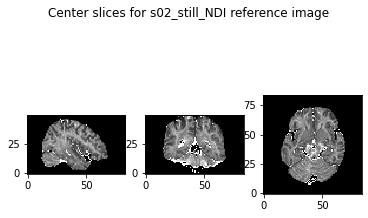

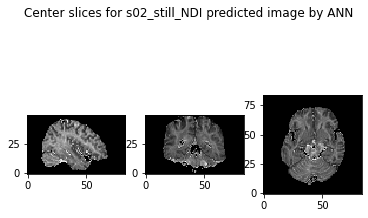

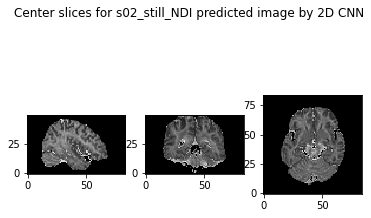

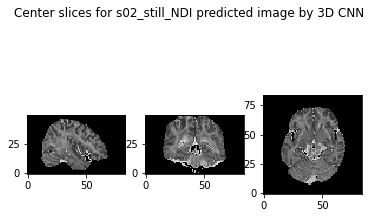

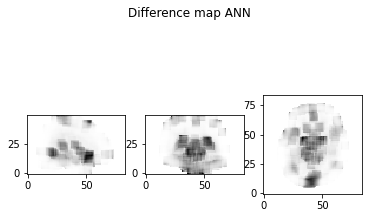

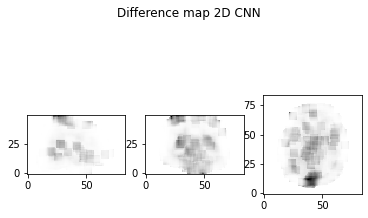

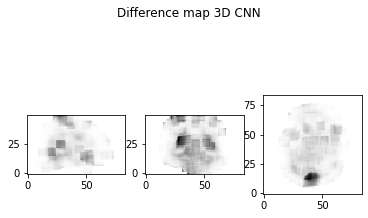

In [53]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_2.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_2.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_2.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>3 layer</strong>

ANN

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_7 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_8 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_15 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
Total params: 60,001
Trainable params: 60,001
Non-trainable params: 0
_________________________________________________

2022-03-14 22:33:19.328752: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:33:19.328913: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


 81/162 [==============>...............] - ETA: 0s - loss: 0.2184 - accuracy: 0.0199

2022-03-14 22:33:19.561987: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:33:19.582424: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 22:33:19.582772: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 22:33:19.583899: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_22_33_19
2022-03-14 22:33:19.584540: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_22_33_19/vw.trace.json.gz
2022-03-14 22:33:19.584706: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 22:33:19.585481: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 0s 3ms/step - loss: 0.1923 - accuracy: 0.0201 - val_loss: 0.1361 - val_accuracy: 0.0223
Epoch 2/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1489 - accuracy: 0.0233 - val_loss: 0.1249 - val_accuracy: 0.0245
Epoch 3/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1352 - accuracy: 0.0271 - val_loss: 0.1166 - val_accuracy: 0.0269
Epoch 4/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.0284 - val_loss: 0.1096 - val_accuracy: 0.0288
Epoch 5/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1175 - accuracy: 0.0299 - val_loss: 0.1009 - val_accuracy: 0.0302
Epoch 6/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1108 - accuracy: 0.0313 - val_loss: 0.0970 - val_accuracy: 0.0298
Epoch 7/100
162/162 [==============================] - 0s 2ms/step - loss: 0.1037 - accuracy: 0.0324 - val_loss: 0.0946 - val_accuracy: 0.0307
Epoch 8/100

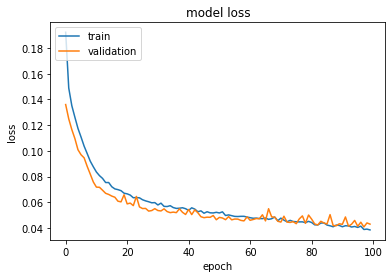

96-fc1d-patch_1-base_1-layer_3
(84, 50, 96)
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_10 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_11 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_16 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
Total params: 60,001
Trainable params: 60,001
Non-trainable params: 0
_____

/home/vw/anaconda3/envs/project/lib/python3.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


In [54]:
# 3 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 3 --train --label_type N"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 3 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 1, 1)           151       
Total params: 175,201
Trainable params: 175,201
Non-trainable params: 0
_______________________________________________

2022-03-14 22:33:53.791961: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:33:53.792112: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


 41/162 [======>.......................] - ETA: 0s - loss: 0.2565 - accuracy: 0.0340

2022-03-14 22:33:54.225911: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:33:54.253025: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 22:33:54.253364: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 22:33:54.254371: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_22_33_54
2022-03-14 22:33:54.254940: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_22_33_54/vw.trace.json.gz
2022-03-14 22:33:54.255037: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 22:33:54.255713: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 1s 6ms/step - loss: 0.1952 - accuracy: 0.0373 - val_loss: 0.1450 - val_accuracy: 0.0084
Epoch 2/100
162/162 [==============================] - 1s 5ms/step - loss: 0.1521 - accuracy: 0.0417 - val_loss: 0.1290 - val_accuracy: 0.0088
Epoch 3/100
162/162 [==============================] - 1s 5ms/step - loss: 0.1392 - accuracy: 0.0429 - val_loss: 0.1244 - val_accuracy: 0.0088
Epoch 4/100
162/162 [==============================] - 1s 5ms/step - loss: 0.1307 - accuracy: 0.0448 - val_loss: 0.1167 - val_accuracy: 0.0095
Epoch 5/100
162/162 [==============================] - 1s 4ms/step - loss: 0.1216 - accuracy: 0.0464 - val_loss: 0.1119 - val_accuracy: 0.0097
Epoch 6/100
162/162 [==============================] - 1s 4ms/step - loss: 0.1150 - accuracy: 0.0477 - val_loss: 0.1167 - val_accuracy: 0.0099
Epoch 7/100
162/162 [==============================] - 1s 4ms/step - loss: 0.1095 - accuracy: 0.0487 - val_loss: 0.1047 - val_accuracy: 0.0100
Epoch 8/100

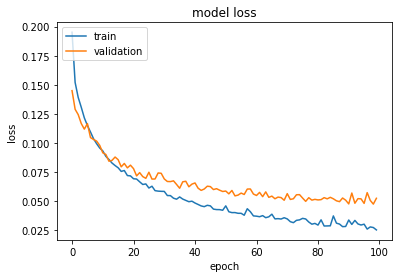

96-conv2d-patch_3-base_1-layer_3
(84, 84, 96)
Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_18 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 82, 82, 1)         151       
Total params: 175,201
Trainable params: 175,201
Non-trainable params: 0
_

In [55]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 3 --train --label_type N"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 3 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 1, 1, 1, 1)        151       
Total params: 434,401
Trainable params: 434,401
Non-trainable params: 0
_______________________________________________

2022-03-14 22:35:09.575687: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:35:09.575848: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


 21/162 [==>...........................] - ETA: 1s - loss: 0.2792 - accuracy: 0.0327

2022-03-14 22:35:10.028742: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:35:10.057448: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 22:35:10.057801: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 22:35:10.058992: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_22_35_10
2022-03-14 22:35:10.059572: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_22_35_10/vw.trace.json.gz
2022-03-14 22:35:10.059691: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 22:35:10.060516: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 2s 11ms/step - loss: 0.1906 - accuracy: 0.0383 - val_loss: 0.1487 - val_accuracy: 0.0084
Epoch 2/100
162/162 [==============================] - 1s 9ms/step - loss: 0.1502 - accuracy: 0.0419 - val_loss: 0.1278 - val_accuracy: 0.0090
Epoch 3/100
162/162 [==============================] - 1s 9ms/step - loss: 0.1372 - accuracy: 0.0445 - val_loss: 0.1279 - val_accuracy: 0.0095
Epoch 4/100
162/162 [==============================] - 1s 8ms/step - loss: 0.1269 - accuracy: 0.0458 - val_loss: 0.1165 - val_accuracy: 0.0098
Epoch 5/100
162/162 [==============================] - 1s 9ms/step - loss: 0.1187 - accuracy: 0.0475 - val_loss: 0.1150 - val_accuracy: 0.0098
Epoch 6/100
162/162 [==============================] - 1s 9ms/step - loss: 0.1136 - accuracy: 0.0482 - val_loss: 0.1182 - val_accuracy: 0.0098
Epoch 7/100
162/162 [==============================] - 1s 9ms/step - loss: 0.1066 - accuracy: 0.0490 - val_loss: 0.1088 - val_accuracy: 0.0101
Epoch 8/10

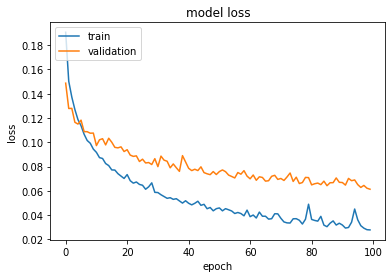

96-conv3d-patch_3-base_1-layer_3
(84, 84, 50)
Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_20 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 82, 82, 48, 1)     151       
Total params: 434,401
Trainable params: 434,401
Non-trainable params: 0
_

In [56]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 3 --train --label_type N"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 3 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

the ssim score for ann is: 0.9851773972248261
the ssim score for 2d cnn is: 0.9738804230279261
the ssim score for 3d cnn is: 0.9638582135564718


Text(0.5, 0.98, 'Difference map 3D CNN')

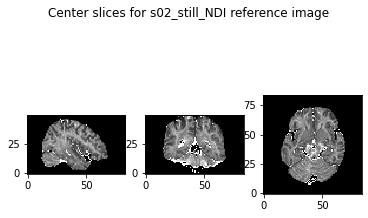

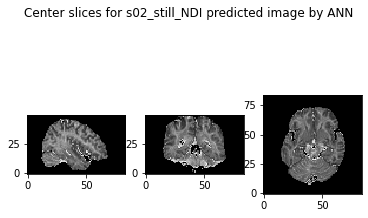

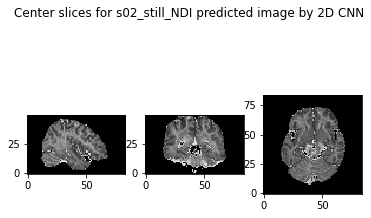

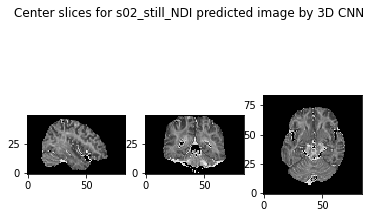

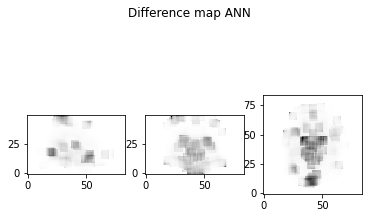

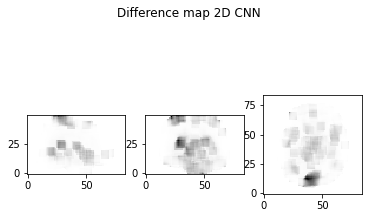

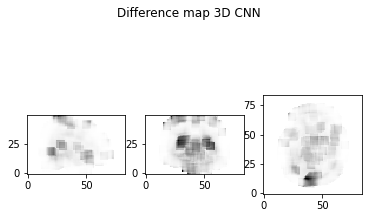

In [57]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_3.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_3.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_3.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>4 layer</strong>

ANN

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_13 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_14 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_15 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_21 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)               

2022-03-14 22:37:25.897109: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:37:25.897261: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


 85/162 [==============>...............] - ETA: 0s - loss: 0.2796 - accuracy: 0.0195

2022-03-14 22:37:26.155031: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:37:26.173170: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 22:37:26.173441: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 22:37:26.174293: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_22_37_26
2022-03-14 22:37:26.174797: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_22_37_26/vw.trace.json.gz
2022-03-14 22:37:26.174867: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 22:37:26.175467: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 0s 3ms/step - loss: 0.2253 - accuracy: 0.0203 - val_loss: 0.1386 - val_accuracy: 0.0231
Epoch 2/100
162/162 [==============================] - 0s 3ms/step - loss: 0.1454 - accuracy: 0.0252 - val_loss: 0.1211 - val_accuracy: 0.0241
Epoch 3/100
162/162 [==============================] - 0s 3ms/step - loss: 0.1288 - accuracy: 0.0286 - val_loss: 0.1097 - val_accuracy: 0.0290
Epoch 4/100
162/162 [==============================] - 0s 3ms/step - loss: 0.1157 - accuracy: 0.0312 - val_loss: 0.0989 - val_accuracy: 0.0313
Epoch 5/100
162/162 [==============================] - 0s 3ms/step - loss: 0.1058 - accuracy: 0.0326 - val_loss: 0.0944 - val_accuracy: 0.0306
Epoch 6/100
162/162 [==============================] - 0s 3ms/step - loss: 0.0972 - accuracy: 0.0336 - val_loss: 0.0877 - val_accuracy: 0.0322
Epoch 7/100
162/162 [==============================] - 0s 3ms/step - loss: 0.0898 - accuracy: 0.0339 - val_loss: 0.0804 - val_accuracy: 0.0316
Epoch 8/100

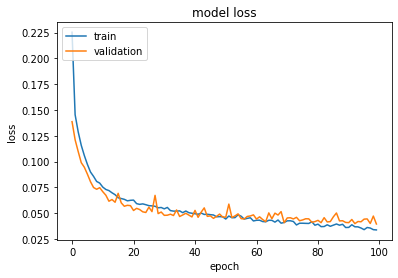

96-fc1d-patch_1-base_1-layer_4
(84, 50, 96)
Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_17 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_18 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_19 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_22 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (D

In [58]:
# 4 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 4 --train --label_type N"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 4 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 1, 1, 1)         

2022-03-14 22:38:07.504055: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:38:07.504145: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


 40/162 [======>.......................] - ETA: 0s - loss: 0.2228 - accuracy: 0.0350

2022-03-14 22:38:07.941047: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:38:07.967599: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 22:38:07.967958: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 22:38:07.968978: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_22_38_07
2022-03-14 22:38:07.969520: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_22_38_07/vw.trace.json.gz
2022-03-14 22:38:07.969644: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 22:38:07.970302: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 1s 6ms/step - loss: 0.1792 - accuracy: 0.0377 - val_loss: 0.1282 - val_accuracy: 0.0088
Epoch 2/100
162/162 [==============================] - 1s 5ms/step - loss: 0.1412 - accuracy: 0.0417 - val_loss: 0.1182 - val_accuracy: 0.0092
Epoch 3/100
162/162 [==============================] - 1s 5ms/step - loss: 0.1296 - accuracy: 0.0441 - val_loss: 0.1060 - val_accuracy: 0.0091
Epoch 4/100
162/162 [==============================] - 1s 5ms/step - loss: 0.1199 - accuracy: 0.0463 - val_loss: 0.1125 - val_accuracy: 0.0096
Epoch 5/100
162/162 [==============================] - 1s 5ms/step - loss: 0.1136 - accuracy: 0.0465 - val_loss: 0.1094 - val_accuracy: 0.0097
Epoch 6/100
162/162 [==============================] - 1s 5ms/step - loss: 0.1070 - accuracy: 0.0477 - val_loss: 0.1005 - val_accuracy: 0.0102
Epoch 7/100
162/162 [==============================] - 1s 5ms/step - loss: 0.1005 - accuracy: 0.0489 - val_loss: 0.0957 - val_accuracy: 0.0101
Epoch 8/100

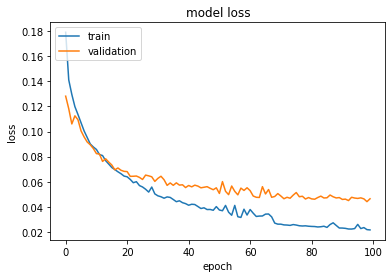

96-conv2d-patch_3-base_1-layer_4
(84, 84, 96)
Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_24 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_

In [59]:
# 4 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 4 --train --label_type N"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 4 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 1, 1, 1, 1)      

2022-03-14 22:39:27.904993: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:39:27.905074: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


 22/162 [===>..........................] - ETA: 1s - loss: 0.2266 - accuracy: 0.0305

2022-03-14 22:39:28.329949: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-03-14 22:39:28.360649: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-03-14 22:39:28.360951: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-14 22:39:28.362026: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_03_14_22_39_28
2022-03-14 22:39:28.362575: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_03_14_22_39_28/vw.trace.json.gz
2022-03-14 22:39:28.362664: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-03-14 22:39:28.363374: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

162/162 [==============================] - 2s 11ms/step - loss: 0.1723 - accuracy: 0.0377 - val_loss: 0.1535 - val_accuracy: 0.0088
Epoch 2/100
162/162 [==============================] - 2s 9ms/step - loss: 0.1453 - accuracy: 0.0417 - val_loss: 0.1355 - val_accuracy: 0.0095
Epoch 3/100
162/162 [==============================] - 1s 9ms/step - loss: 0.1328 - accuracy: 0.0441 - val_loss: 0.1256 - val_accuracy: 0.0094
Epoch 4/100
162/162 [==============================] - 1s 9ms/step - loss: 0.1221 - accuracy: 0.0461 - val_loss: 0.1154 - val_accuracy: 0.0097
Epoch 5/100
162/162 [==============================] - 1s 9ms/step - loss: 0.1133 - accuracy: 0.0480 - val_loss: 0.1178 - val_accuracy: 0.0104
Epoch 6/100
162/162 [==============================] - 1s 9ms/step - loss: 0.1075 - accuracy: 0.0493 - val_loss: 0.1132 - val_accuracy: 0.0103
Epoch 7/100
162/162 [==============================] - 1s 9ms/step - loss: 0.1014 - accuracy: 0.0499 - val_loss: 0.1098 - val_accuracy: 0.0101
Epoch 8/10

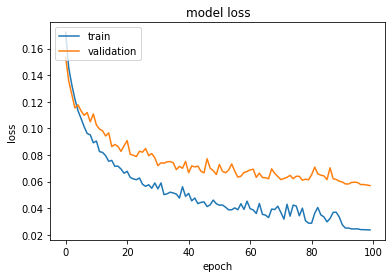

96-conv3d-patch_3-base_1-layer_4
(84, 84, 50)
Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_26 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_

In [60]:
# 4 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 4 --train --label_type N"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 4 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_4.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_4.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_4.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>5 layer</strong>

ANN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 5 --train --label_type N"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 5 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 5 --train --label_type N"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 5 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 5 --train --label_type N"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 5 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_5.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_5.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_5.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>6 layer</strong>

ANN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 6 --train --label_type N"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 6 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 6 --train --label_type N"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 6 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 6 --train --label_type N"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 6 --label_type N"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-NDI-96-fc1d-patch_1-base_1-layer_6.nii'
cnn2d_path = '../Net/nii/s02_still-NDI-96-conv2d-patch_3-base_1-layer_6.nii'
cnn3d_path = '../Net/nii/s02_still-NDI-96-conv3d-patch_3-base_1-layer_6.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_NDI_img_data[26, :, :]
ref_slice_1 = s02_NDI_img_data[:, 30, :]
ref_slice_2 = s02_NDI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_NDI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_NDI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_NDI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

___

Training subject: s01_still</br>
Test subject: s02_still</br>
Outcome: ODI</br>


<h4>Data Preprocessing</h4>

In [ ]:
"""
Generate the base dataset for s01_still and s02_still first.
"""
cmd = "--base --label_type O --subjects s01_still s02_still"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset ODI for ANN.
"""
cmd = "--subjects s01_still --fc1d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset ODI for 2D CNN.
"""
cmd = "--subjects s01_still --conv2d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset ODI for 3D CNN.
"""
cmd = "--subjects s01_still --conv3d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Using nib to fetch the  data, used for evaluation
"""
s02_ODI_path = '../Data-NODDI/s02_still/s02_still_ODI.nii'
s02_mask_path = '../Net/datasets/mask/mask_s02_still.nii'
s02_ODI_img = nib.load(s02_ODI_path)
s02_ODI_img_data = s02_ODI_img.get_fdata()
s02_mask_img = nib.load(s02_mask_path)
s02_mask_img_data = s02_mask_img.get_fdata()

<strong>1 layer</strong>

ANN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 1 --train --label_type O"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 1 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 1 --train --label_type O"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 1 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 1 --train --label_type O"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 1 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_1.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_1.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_1.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>2 layer</strong>

ANN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 2 --train --label_type O"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 2 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 2 --train --label_type O"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 2 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 2 --train --label_type O"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 2 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_2.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_2.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_2.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>3 layer</strong>

ANN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 3 --train --label_type O"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 3 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 3 --train --label_type O"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 3 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 3 --train --label_type O"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 3 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_3.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_3.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_3.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>4 layer</strong>

ANN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 4 --train --label_type O"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 4 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 2 --train --label_type O"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 2 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 3 --train --label_type O"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 3 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_1.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_1.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_1.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")
pred_slice_0 = pred_ODI_img_data[26, :, :]
pred_slice_1 = pred_ODI_img_data[:, 30, :]
pred_slice_2 = pred_ODI_img_data[:, :, 16]
show_slices([pred_slice_0, pred_slice_1, pred_slice_2])
plt.suptitle("Center slices for s02_still_ODI predicted image")

<strong>5 layer</strong>

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --DWI 96 --model fc1d --layer 5 --train --label_type O"
plot_loss(cmd)

In [ ]:
# 5 layer testing
cmd = "--test_subjects s02_still --DWI 96 --model fc1d --layer 5 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_5.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_5.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_5.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>6 layer</strong>

ANN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 6 --train --label_type O"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 6 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 6 --train --label_type O"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 6 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 6 --train --label_type O"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 6 --label_type O"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-ODI-96-fc1d-patch_1-base_1-layer_6.nii'
cnn2d_path = '../Net/nii/s02_still-ODI-96-conv2d-patch_3-base_1-layer_6.nii'
cnn3d_path = '../Net/nii/s02_still-ODI-96-conv3d-patch_3-base_1-layer_6.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_ODI_img_data[26, :, :]
ref_slice_1 = s02_ODI_img_data[:, 30, :]
ref_slice_2 = s02_ODI_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_ODI reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_ODI predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_ODI predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

Training subject: s01_still</br>
Test subject: s02_still</br>
Outcome: FWF</br>

<h4>Data Preprocessing</h4>

In [ ]:
"""
Generate the base dataset for s01_still and s02_still first.
"""
cmd = "--base --label_type F --subjects s01_still s02_still"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset FWF for ANN.
"""
cmd = "--subjects s01_still --fc1d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset FWF for 2D CNN.
"""
cmd = "--subjects s01_still --conv2d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Generate training dataset FWF for 3D CNN.
"""
cmd = "--subjects s01_still --conv3d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

In [ ]:
"""
Using nib to fetch the  data, used for evaluation
"""
s02_FWF_path = '../Data-NODDI/s02_still/s02_still_FWF.nii'
s02_mask_path = '../Net/datasets/mask/mask_s02_still.nii'
s02_FWF_img = nib.load(s02_FWF_path)
s02_FWF_img_data = s02_FWF_img.get_fdata()
s02_mask_img = nib.load(s02_mask_path)
s02_mask_img_data = s02_mask_img.get_fdata()

<strong>1 layer</strong>

ANN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 1 --train --label_type F"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 1 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 1 --train --label_type F"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 1 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 1 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 1 --train --label_type F"
plot_loss(cmd)
# 1 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 1 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_1.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_1.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_1.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>2 layer</strong>

ANN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 2 --train --label_type F"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 2 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 2 --train --label_type F"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 2 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 2 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 2 --train --label_type F"
plot_loss(cmd)
# 2 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 2 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_2.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_2.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_2.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>3 layer</strong>

ANN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 3 --train --label_type F"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 3 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 3 --train --label_type F"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 3 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 3 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 3 --train --label_type F"
plot_loss(cmd)
# 3 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 3 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_3.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_3.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_3.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>4 layer</strong>

ANN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 4 --train --label_type F"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 4 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 4 --train --label_type F"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 4 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 4 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 4 --train --label_type F"
plot_loss(cmd)
# 4 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 4 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_4.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_4.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_4.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>5 layer</strong>

ANN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 5 --train --label_type F"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 5 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 5 --train --label_type F"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 5 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 5 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 5 --train --label_type F"
plot_loss(cmd)
# 5 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 5 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_5.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_5.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_5.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")

<strong>6 layer</strong>

ANN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model fc1d --layer 6 --train --label_type F"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model fc1d --layer 6 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

2D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv2d --layer 6 --train --label_type F"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv2d --layer 6 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

3D CNN

In [ ]:
# 6 layer training
cmd = "--train_subjects s01_still --model conv3d --layer 6 --train --label_type F"
plot_loss(cmd)
# 6 layer testing
cmd = "--test_subjects s02_still --model conv3d --layer 6 --label_type F"
args = model_parser().parse_args(cmd.split())
test_model(args)

In [ ]:
# load the reference img and pred img
ann_path = '../Net/nii/s02_still-FWF-96-fc1d-patch_1-base_1-layer_6.nii'
cnn2d_path = '../Net/nii/s02_still-FWF-96-conv2d-patch_3-base_1-layer_6.nii'
cnn3d_path = '../Net/nii/s02_still-FWF-96-conv3d-patch_3-base_1-layer_6.nii'
ann_img = nib.load(ann_path)
ann_data = ann_img.get_fdata()
cnn2d_img = nib.load(cnn2d_path)
cnn2d_data = cnn2d_img.get_fdata()
cnn3d_img = nib.load(cnn3d_path)
cnn3d_data = cnn3d_img.get_fdata()

# visualise both ref img and pred img
ref_slice_0 = s02_FWF_img_data[26, :, :]
ref_slice_1 = s02_FWF_img_data[:, 30, :]
ref_slice_2 = s02_FWF_img_data[:, :, 16]
show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
plt.suptitle("Center slices for s02_still_FWF reference image")

ann0 = ann_data[26, :, :]
ann1 = ann_data[:, 30, :]
ann2 = ann_data[:, :, 16]
show_slices([ann0, ann1, ann2])
plt.suptitle("Center slices for s02_still_FWF predicted image by ANN")
(annscore, anndiff) = compare_ssim(ann_data, s02_NDI_img_data, full=True)
print('the ssim score for ann is: ' + str(annscore))

cnn2d0 = cnn2d_data[26, :, :]
cnn2d1 = cnn2d_data[:, 30, :]
cnn2d2 = cnn2d_data[:, :, 16]
show_slices([cnn2d0, cnn2d1, cnn2d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 2D CNN")
(cnn2dscore, cnn2ddiff) = compare_ssim(cnn2d_data, s02_NDI_img_data, full=True)
print('the ssim score for 2d cnn is: ' + str(cnn2dscore))

cnn3d0 = cnn3d_data[26, :, :]
cnn3d1 = cnn3d_data[:, 30, :]
cnn3d2 = cnn3d_data[:, :, 16]
show_slices([cnn3d0, cnn3d1, cnn3d2])
plt.suptitle("Center slices for s02_still_FWF predicted image by 3D CNN")
(cnn3dscore, cnn3ddiff) = compare_ssim(cnn3d_data, s02_NDI_img_data, full=True)
print('the ssim score for 3d cnn is: ' + str(cnn3dscore))

# plot the difference map between the imgs by the lib
anndiff0 = anndiff[26, :, :]
anndiff1 = anndiff[:, 30, :]
anndiff2= anndiff[:, :, 16]
show_slices([anndiff0, anndiff1, anndiff2])
plt.suptitle("Difference map ANN")

cnn2ddiff0 = cnn2ddiff[26, :, :]
cnn2ddiff1 = cnn2ddiff[:, 30, :]
cnn2ddiff2 = cnn2ddiff[:, :, 16]
show_slices([cnn2ddiff0, cnn2ddiff1, cnn2ddiff2])
plt.suptitle("Difference map 2D CNN")

cnn3ddiff0 = cnn3ddiff[26, :, :]
cnn3ddiff1 = cnn3ddiff[:, 30, :]
cnn3ddiff2 = cnn3ddiff[:, :, 16]
show_slices([cnn3ddiff0, cnn3ddiff1, cnn3ddiff2])
plt.suptitle("Difference map 3D CNN")